# SGDR - Stochastic Gradient Descent with Warm Restarts

In this tutorial we are going to be looking at the `SGDR` or as referred to in the `timm` library - the `cosine` scheduler in little more detail with all the supporting hyperparams. 

The SGDR schedule as mentioned in the [paper](https://arxiv.org/abs/1608.03983) looks like: 

<img alt="SGDR" src="images/SGDR.png" width="500">

In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
from timm.scheduler.cosine_lr import CosineLRScheduler
from nbdev.showdoc import show_doc

In [3]:
show_doc(CosineLRScheduler)

<h2 id="CosineLRScheduler" class="doc_header"><code>class</code> <code>CosineLRScheduler</code><a href="timm/scheduler/cosine_lr.py#L18" class="source_link" style="float:right">[source]</a></h2>

> <code>CosineLRScheduler</code>(**`optimizer`**:`Optimizer`, **`t_initial`**:`int`, **`lr_min`**:`float`=*`0.0`*, **`cycle_mul`**:`float`=*`1.0`*, **`cycle_decay`**:`float`=*`1.0`*, **`cycle_limit`**:`int`=*`1`*, **`warmup_t`**=*`0`*, **`warmup_lr_init`**=*`0`*, **`warmup_prefix`**=*`False`*, **`t_in_epochs`**=*`True`*, **`noise_range_t`**=*`None`*, **`noise_pct`**=*`0.67`*, **`noise_std`**=*`1.0`*, **`noise_seed`**=*`42`*, **`k_decay`**=*`1.0`*, **`initialize`**=*`True`*) :: `Scheduler`

Cosine decay with restarts.
This is described in the paper https://arxiv.org/abs/1608.03983.

Inspiration from
https://github.com/allenai/allennlp/blob/master/allennlp/training/learning_rate_schedulers/cosine.py

k-decay option based on `k-decay: A New Method For Learning Rate Schedule` - https://arxiv.org/abs/2004.05909

The `CosineLRScheduler` as shown above accepts an `optimizer` and also some hyperparams which we will look into in detail below. We will first see how we can train models using the `cosine` LR scheduler by first using `timm` training docs and then look at how we can use this scheduler as standalone scheduler for our custom training scripts. 

## Using `cosine` scheduler with `timm` training script

To train models using the `cosine` scheduler we simply update the training script args passed by passing in `--sched cosine` parameter alongside the necessary hyperparams. In this section we will also look at how each of the hyperparams update the `cosine` scheduler. 

> NOTE: In the paper this scheduler is referred to as `SGDR` but in `timm` this is referred to as `cosine` scheduler. They are both one and the same with minor implementation difference. 

The training command to use `cosine` scheduler looks something like: 

```python 
python train.py ../imagenette2-320/ --sched cosine
```

## Args

This way we start to use the `cosine` scheduler with all the defaults. Let's now look at the associated hyperparams and how that updates the annealing schedule. 

### `optimizer`

This is the `optimizer` that will be used for the training process. 

In [4]:
from timm import create_model 
from timm.optim import create_optimizer
from types import SimpleNamespace

In [5]:
model = create_model('resnet34')

args = SimpleNamespace()
args.weight_decay = 0
args.lr = 1e-4
args.opt = 'adam' 
args.momentum = 0.9

optimizer = create_optimizer(args, model)

This `optimizer` object created using `create_optimizer` is what get's passed to the `optimizer` argument. 

### `t_initial` 

The initial number of epochs. Example, 50, 100 etc. 

### `cycle_mul`

Defaults to 1.0. Updates the `SGDR` schedule annealing. 

<img alt="SGDR_params" src="images/SGDR_params.png" width="500">

As shown in the image below, here **T<sub>0</sub>** is the `t_initial` hyperparameter and **T<sub>mult</sub>** is the `cycle_mul` hyperparameter. One can see how updating these parameters updates the scheduler. 

### `lr_min` 

Defaults to `1e-5`. The minimum learning rate to use during the scheduling. The learning rate does not ever go below this value. 

### `decay_rate`

When `decay_rate` > 0 and <1., at every restart the learning rate is decayed by new learning rate which equals `lr * decay_rate`. So if `decay_rate=0.5`, then in that case, the new learning rate becomes half the initial `lr`. 

In [6]:
from matplotlib import pyplot as plt

def get_lr_per_epoch(scheduler, num_epoch):
    lr_per_epoch = []
    for epoch in range(num_epoch):
        lr_per_epoch.append(scheduler.get_epoch_values(epoch))
    return lr_per_epoch

#### `decay_rate=1.` or no decay

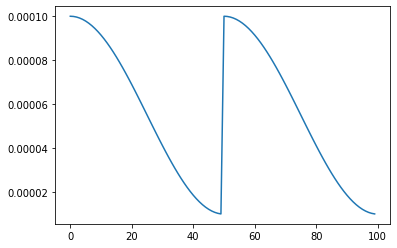

In [7]:
num_epoch = 50
scheduler = CosineLRScheduler(optimizer, t_initial=num_epoch, cycle_decay=1., cycle_limit=2, lr_min=1e-5)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch*2)

plt.plot([i for i in range(num_epoch*2)], lr_per_epoch);

#### `decay_rate=0.5` 

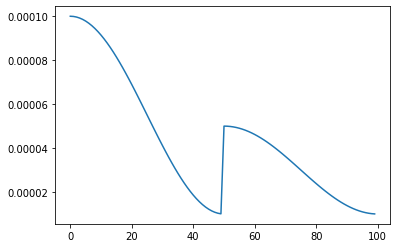

In [8]:
num_epoch = 50
scheduler = CosineLRScheduler(optimizer, t_initial=num_epoch, cycle_decay=0.5, cycle_limit=2, lr_min=1e-5)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch*2)

plt.plot([i for i in range(num_epoch*2)], lr_per_epoch);

### `warmup_t` 

Defines the number of warmup epochs. 

### `warmup_lr_init` 

The initial learning rate during warmup. 

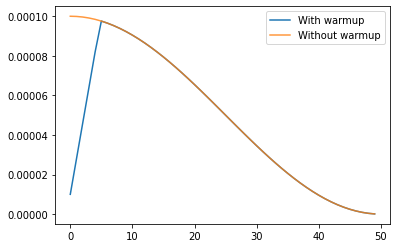

In [9]:
num_epoch = 50
scheduler = CosineLRScheduler(optimizer, t_initial=num_epoch, warmup_t=5, warmup_lr_init=1e-5)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
plt.plot([i for i in range(num_epoch)], lr_per_epoch, label="With warmup");

num_epoch = 50
scheduler = CosineLRScheduler(optimizer, t_initial=num_epoch)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
plt.plot([i for i in range(num_epoch)], lr_per_epoch, label="Without warmup", alpha=0.8);

plt.legend();

As we can see by setting up `warmup_t` and `warmup_lr_init`, the `cosine` scheduler first starts with a value of `warmup_lr_init`, then gradually progresses up to the `initial_lr` set in the optimizer which is 1e-4. It takes `warmup_t` number of epochs to go from `warmup_lr_init` to `initial_lr`. 

### `warmup_prefix`

Defaults to `False`. If set to `True`, then every new epoch number equals `epoch = epoch - warmup_t`.

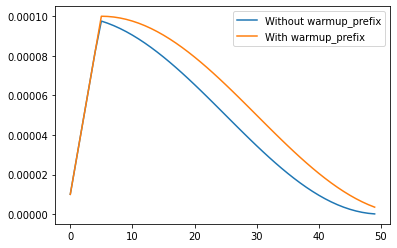

In [10]:
num_epoch = 50
scheduler = CosineLRScheduler(optimizer, t_initial=num_epoch, warmup_t=5, warmup_lr_init=1e-5)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
plt.plot([i for i in range(num_epoch)], lr_per_epoch, label="Without warmup_prefix");

num_epoch = 50
scheduler = CosineLRScheduler(optimizer, t_initial=num_epoch, warmup_t=5, warmup_lr_init=1e-5, warmup_prefix=True)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
plt.plot([i for i in range(num_epoch)], lr_per_epoch, label="With warmup_prefix");

plt.legend();

In the example above we can see how the `warmup_prefix` updates the LR annealing schedule. 

### `cycle_limit`

The number of maximum restarts in SGDR. 

#### `cycle_limit=1`

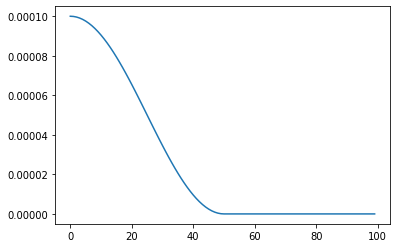

In [11]:
num_epoch = 50
scheduler = CosineLRScheduler(optimizer, t_initial=num_epoch, cycle_limit=1)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch*2)

plt.plot([i for i in range(num_epoch*2)], lr_per_epoch);

#### `cycle_limit=2`

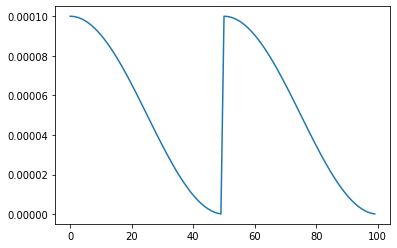

In [12]:
num_epoch = 50
scheduler = CosineLRScheduler(optimizer, t_initial=num_epoch, cycle_limit=2)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch*2)

plt.plot([i for i in range(num_epoch*2)], lr_per_epoch);

### `t_in_epochs`

If set to False, the learning rates returned for epoch `t` are `None`.

In [13]:
num_epoch = 50
scheduler = CosineLRScheduler(optimizer, t_initial=num_epoch, t_in_epochs=False)
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)

lr_per_epoch[:5]

[None, None, None, None, None]

### `noise_range_t`

Add noise to learning rate scheduler. 

### `noise_pct`

The amount of noise to be added. Defaults to 0.67.

### `noise_std`

Noise standard deviation. Defaults to 1.0.

### `noise_seed`

 Noise seed to use. Defaults to 42.

### `initialize`

If set to True, then, the an attributes `initial_lr` is set to each param group. Defaults to `True`.

> NOTE: we leave it up to the reader to try and experiment how the LR annealing scheduling get's updated by adding in noise hyperparams. 